In [1]:
%matplotlib inline


`A Simple Framework for Contrastive Learning of Visual Representations <https://arxiv.org/abs/2002.05709>`_.


## Imports

In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import lightly
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from PIL import Image
import numpy as np

/home/tidianes/miniconda3/envs/tid_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration



In [4]:
num_workers = 8
batch_size = 256
seed = 1
max_epochs = 20
input_size = 32
num_ftrs = 32

In [3]:
dataset_train_simclr = torchvision.datasets.CIFAR10(root='data/', train=True,
                                        download=True)#, transform=transform)
dataset_test = torchvision.datasets.CIFAR10(root='data/', train=False,
                                       download=True)#, transform=transform)

"""
dataset_train_simclr = lightly.data.LightlyDataset(
    input_dir=path_to_data
)

dataset_test = lightly.data.LightlyDataset(
    input_dir=path_to_data,
    transform=test_transforms
)
"""

100%|██████████| 170498071/170498071 [00:28<00:00, 6018293.97it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


'\ndataset_train_simclr = lightly.data.LightlyDataset(\n    input_dir=path_to_data\n)\n\ndataset_test = lightly.data.LightlyDataset(\n    input_dir=path_to_data,\n    transform=test_transforms\n)\n'

## Setup data augmentations and loaders


In [5]:

collate_fn = lightly.data.SimCLRCollateFunction(
    input_size=input_size,
    vf_prob=0.5,
    rr_prob=0.5
)

"""

collate_fn = lightly.data.SimCLRCollateFunction(
    input_size=input_size,
    vf_prob=0.5,
    rr_prob=0.5,
    cj_prob=0.0,
    random_gray_scale=0.0
)
"""

# We create a torchvision transformation for embedding the dataset after 
# training
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])



dataloader_train_simclr = torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
    num_workers=num_workers
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

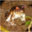

In [15]:
dataset_train_simclr[0][0]

## Create the SimCLR Model
ResNet-18 backbone from Torchvision. 
Lightly provides implementations of the SimCLR projection head and loss function in the `SimCLRProjectionHead` and `NTXentLoss` classes. 



In [6]:
from lightly.models.modules.heads import SimCLRProjectionHead
from lightly.loss import NTXentLoss


class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone, adapt it to cifar and remove the classification head
        resnet = torchvision.models.resnet18(pretrained=False, num_classes=10)
        resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        resnet.maxpool = nn.Identity()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optim, max_epochs
        )
        return [optim], [scheduler]

In [8]:
gpus = 1 if torch.cuda.is_available() else 0

model = SimCLRModel()
trainer = pl.Trainer(
    max_epochs=max_epochs, gpus=gpus#, progress_bar_refresh_rate=100
)


/home/tidianes/miniconda3/envs/tid_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
#train model
trainer.fit(model, dataloader_train_simclr)

Missing logger folder: /media/tidianes/linux_home/tidiane/dev/featurePFN/lightning_logs

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
45.989    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/195 [00:00<?, ?it/s] 

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/tidianes/miniconda3/envs/tid_env/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tidianes/miniconda3/envs/tid_env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/home/tidianes/miniconda3/envs/tid_env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/tidianes/miniconda3/envs/tid_env/lib/python3.10/site-packages/lightly/data/collate.py", line 82, in forward
    fnames = [item[2] for item in batch]
  File "/home/tidianes/miniconda3/envs/tid_env/lib/python3.10/site-packages/lightly/data/collate.py", line 82, in <listcomp>
    fnames = [item[2] for item in batch]
IndexError: tuple index out of range


In [9]:
#save backbone
"""
pretrained_resnet_backbone = model.backbone

state_dict = {
    'resnet18_parameters': pretrained_resnet_backbone.state_dict()
}
torch.save(state_dict, 'models/pretrained_resnet_backbone.pth')
"""


"\npretrained_resnet_backbone = model.backbone\n\nstate_dict = {\n    'resnet18_parameters': pretrained_resnet_backbone.state_dict()\n}\ntorch.save(state_dict, 'model.pth')\n"

In [10]:
# load the model in a new file for inference
resnet18_new = torchvision.models.resnet18()

# note that we need to create exactly the same backbone in order to load the weights
backbone_new = nn.Sequential(*list(resnet18_new.children())[:-1])

ckpt = torch.load('models/model_color.pth')
backbone_new.load_state_dict(ckpt['resnet18_parameters'])

model.backbone = backbone_new

Next we create a helper function to generate embeddings
from our test images using the model we just trained.
Note that only the backbone is needed to generate embeddings,
the projection head is only required for the training.
Make sure to put the model into eval mode for this part!



In [11]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, label, fnames in dataloader:
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


model.eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)

## Visualize Nearest Neighbors
 Let's look at the trained embedding and visualize the nearest neighbors for 
 a few random samples.

 We create some helper functions to simplify the work



In [12]:
def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array
    """
    img = Image.open(filename)
    return np.asarray(img)


def plot_knn_examples(embeddings, filenames, n_neighbors=3, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors
    """
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(path_to_data, filenames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f'd={distances[idx][plot_x_offset]:.3f}')
            # let's disable the axis
            plt.axis('off')

Let's do the plot of the images. The leftmost image is the query image whereas
the ones next to it on the same row are the nearest neighbors.
In the title we see the distance of the neigbor.



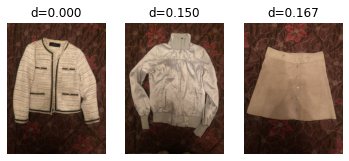

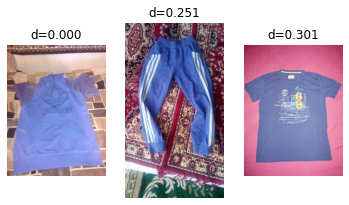

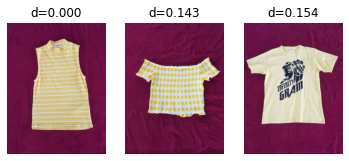

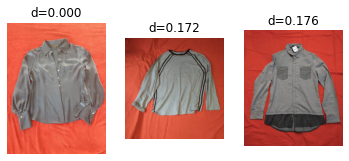

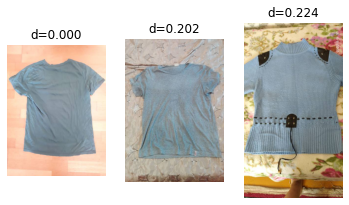

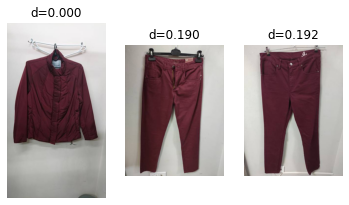

In [13]:
plot_knn_examples(embeddings, filenames)

Open image from Url


In [14]:
from PIL import Image
import requests
from io import BytesIO

url = "https://www.helikon-tex.com/media/catalog/product/cache/4/image/9df78eab33525d08d6e5fb8d27136e95/s/p/sp-pgm-dc-11.jpg"


response = requests.get(url)
img = Image.open(BytesIO(response.content))

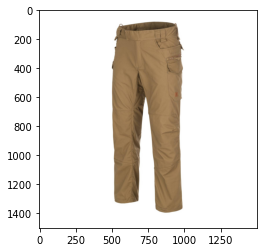

In [15]:
plt.imshow(img)

In [25]:
def url_nearest_images(model, url, n_neighbors=5):
    """Generates representations for a given image
    """

    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    print("ORIGINAL IMAGE AND NEIGHBORS IN DATABASE")
    plt.imshow(img)

    img = test_transforms(img)
    img = torch.unsqueeze(img, 0)

    img = img.to(model.device)
    emb = model.backbone(img)

    emb = emb.flatten(start_dim=1)

    emb = emb.detach().numpy()

    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(emb)



    # loop through our randomly picked samples
    for idx in range(len(emb)):
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(path_to_data, filenames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f'd={distances[idx][plot_x_offset]:.3f}')
            # let's disable the axis
            plt.axis('off')




ORIGINAL IMAGE AND NEIGHBORS IN DATABASE


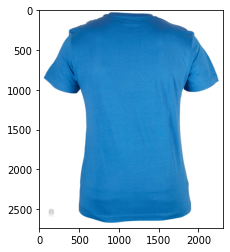

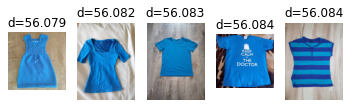

In [26]:
url = "https://img.kytary.com/eshop_de/velky_v2/na/637329305569630000/bd547319/64771944/ant-tshirt-ant-blu-l.jpg"
url_nearest_images(model, url)